# **Hiring assignment**
## Find list of unique authors and institutions form publications dataset

In [1]:
# Run this cell if working in Colab envinronment
try:
  %pycountry
except Exception:
  !pip install pycountry

     |████████████████████████████████| 10.1MB 7.6MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746883 sha256=7f613bcfb875d7bd5200a405432d9df10c9ff9be4090ea29ca83875ee472b35b
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [2]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import re
import seaborn as sns

import pycountry

from difflib import SequenceMatcher
from gensim.parsing.preprocessing import strip_non_alphanum

In [3]:
!gzip -d "./publications_min.csv.gz"

### Read dataset

In [4]:
publications_df = pd.read_csv("publications_min.csv", index_col=0)
publications_df

,temp_id,abstract,title,pubdate,journal,affiliations,publication_uuid,authors
0,0,The pulmonary effects of hyperventilation foll...,Acute respiratory failure following pharmacolo...,1988-01-01 00:00:00,"Intensive care medicine, Issue: 1, Volume: 15 ...","National Institutes of Health, Laboratory of T...",0.0,"['D Mascheroni', 'T Kolobow', 'R Fumagalli', '..."
1,1,Ten patients with acute respiratory failure (A...,Morphological response to positive end expirat...,1986-01-01 00:00:00,"Intensive care medicine, Issue: 3, Volume: 12 ...",", , , , , , , , ,",1.0,"['L Gattinoni', 'D Mascheroni', 'A Torresin', ..."
2,2,A group of 36 patients with severe adult respi...,The role of total static lung compliance in th...,1984-01-01 00:00:00,"Intensive care medicine, Issue: 3, Volume: 10 ...",", , , , , , , , ,",2.0,"['L Gattinoni', 'A Pesenti', 'M L Caspani', 'A..."
3,3,Functional residual capacity (FRC) was measure...,Perioperative changes in functional residual c...,1988-04-01 00:00:00,"British journal of anaesthesia, Issue: 5, Volu...","Istituto di Anestesiologia e Rianimazione, Uni...",3.0,"['G Damia', 'D Mascheroni', 'M Croci', 'L Tare..."
4,4,NaN,ECMO revisited.,1987-01-01 00:00:00,The International journal of artificial organs...,", , , , , , , ,",4.0,"['T Kolobow', 'L Gattinoni', 'A Pesenti', 'M S..."
...,...,...,...,...,...,...,...,...
9995,9995,Global demethylation of DNA which marks the on...,Hypomethylation of paternal DNA in the late mo...,2008-03-04 09:00:00,The International journal of developmental bio...,"Department of Developmental Biology, Max Planc...",9995.0,"['Zbigniew Polanski', 'Nami Motosugi', 'Chizuk..."
9996,9996,NaN,The diagnostic challenge of a vitamin K antago...,2017-05-17 06:00:00,"British journal of anaesthesia, Issue: 5, Volu...","Vienna, Austria., Vienna, Austria., Vienna, Au...",9996.0,"['A Pausch', 'St Koch', 'M Frossard', 'M Wiege..."
9997,9997,Risk factors for early bleeding complications ...,Risk factors for early bleeding complications ...,2019-08-14 06:00:00,Transplant international : official journal of...,Division of Cardiac Thoracic Vascular Anesthes...,9997.0,"['Dieter Adelmann', 'Stefan Koch', 'Johannes M..."
9998,9998,"In the retina, chemical and electrical synapse...",Pannexin1 in the outer retina of the zebrafish...,2009-05-05 09:00:00,"Neuroscience, Issue: 4, Volume: 162 15, Sep, 2009",Department of Neuroanatomy and Molecular Brain...,9998.0,"['N Prochnow', 'S Hoffmann', 'R Vroman', 'J Kl..."


### Preprocess column with authors names

In [5]:
authors = publications_df.authors.dropna(how="all")
authors

0       ['D Mascheroni', 'T Kolobow', 'R Fumagalli', '...
1       ['L Gattinoni', 'D Mascheroni', 'A Torresin', ...
2       ['L Gattinoni', 'A Pesenti', 'M L Caspani', 'A...
3       ['G Damia', 'D Mascheroni', 'M Croci', 'L Tare...
4       ['T Kolobow', 'L Gattinoni', 'A Pesenti', 'M S...
                              ...                        
9995    ['Zbigniew Polanski', 'Nami Motosugi', 'Chizuk...
9996    ['A Pausch', 'St Koch', 'M Frossard', 'M Wiege...
9997    ['Dieter Adelmann', 'Stefan Koch', 'Johannes M...
9998    ['N Prochnow', 'S Hoffmann', 'R Vroman', 'J Kl...
9999                               ['Sven Olaf Hoffmann']
Name: authors, Length: 9893, dtype: object

In [6]:
# Check type of data within a rows
sample_value = authors.iloc[0]
print(isinstance(sample_value, list))
print(isinstance(sample_value, str))

False
True


**The task is to provide unique names of authors, suggesting that the initials are not of interest to us. Although we lose some information when we get rid of them, based on this dataset, we cannot tell if John S Doe, John Sebastian Doe or John Doe are three different people. Therefore, with this step I will unify this information, assuming that my goal is only to get the names and surnames and not to find the presence of a specific researcher in the dataset.**

In [7]:
def remove_initials(name):
    """Function takes a string as a parameter and modifies it by removing single letters"""
    pattern = "\\b[A-Z]+(?:\\.|\\s+|$)"
    return re.sub(pattern, "", name)

In [8]:
remove_initials("Christian Martin H")

'Christian Martin '

In [9]:
# Take list of names put each name on separate row
unique_signatures = set(itertools.chain.from_iterable(authors.apply(lambda x: eval(x))))
# Remove initials and normalize names by lowercasing them
unique_signatures = list(map(remove_initials, unique_signatures))
unique_signatures = list(map(str.lower, unique_signatures))
# Show few examples
random.sample(unique_signatures, 10)

['piera anna martino',
 'thomas gill',
 'christopher margono',
 'gere luder',
 'weiqiang chen',
 'sergey bessonov',
 'damian lobato-marquez',
 'enrico galmozzi',
 'christoph auf der maur',
 'annette schmidt']

In [10]:
authors_df = pd.DataFrame(list(map(lambda x: x.rsplit(" ", 1), list(unique_signatures))), columns=["name", "lastname"])
authors_df.head(15)

,name,lastname
0,settecase,None
1,uttara,basu
2,oroszlan,None
3,mcfall,None
4,victor,navia
5,seebass,None
6,tarpley,None
7,heiko,scholl
8,emma,gardner
9,zhijian,liu


Okay, so we can see that some data got corrupted during the preprocessing. This is the result of the lack of authors' names and the design decision to remove the initials from the names. Empty lines in the names column will result from situations where the author had only initials, eg G R R Martin. Empty lines in the lastname column result from writing the last name as a single letter, eg Christian Martin H.

As a result, this code in some cases (where the first name is not specified or was an initial) assigns the surname as the first name. In this case, we will not consider it a problem as we want to return a list of full names and not just surnames.

In [11]:
num_of_empty_rows = sum(authors_df.name.isin(['', None])) + sum(authors_df.lastname.isin(['', None]))
print(f"Number of empty names or lastnames: {num_of_empty_rows}")

Number of empty names or lastnames: 12122


In [12]:
# Clear empty or incomplete records from data
authors_df = authors_df.mask(authors_df.eq("None") | authors_df.eq("")).dropna()

In [13]:
num_of_empty_rows = sum(authors_df.name.isin(['', None])) + sum(authors_df.lastname.isin(['', None]))
print(f"""Number of empty names or lastnames after cleaning: {num_of_empty_rows}""")

Number of empty names or lastnames after cleaning: 0


In [14]:
authors_df = authors_df.drop_duplicates(subset=["name", "lastname"])

In [15]:
# Create new dataframe with names grupped by lastname
authors_groupped_df = authors_df.groupby("lastname")["name"].apply(list).reset_index(name="groupped_names")
authors_groupped_df

,lastname,groupped_names
0,a-brouwer,[anne-marie]
1,aa,[frank van der]
2,aalten,[pauline]
3,aanensen,[david]
4,aarab,[ghizlane]
...,...,...
23221,zwyssig,[adrian]
23222,zygmunt,[michel]
23223,zyluk,[andrzey]
23224,zypen,[dominic van der]


In [16]:
# Show authors that share same surname
authors_groupped_df[authors_groupped_df.groupped_names.map(len) > 1]

,lastname,groupped_names
17,abbasi,"[reza, amir, zainab]"
20,abbate,"[maria ida, antonio]"
27,abdalla,"[safa, fabio, adibe]"
48,abel,"[martin, laurent, mark, steffen]"
54,abera,"[semaw, semaw ferede]"
...,...,...
23157,zong,"[wei-xing, xiangang]"
23163,zorn,"[gilad, aaron]"
23172,zou,"[weiping, zhengzhi, xiaonong, zhen, xiao nong]"
23177,zschocke,"[jurgen, johannes]"


Above we can see an interesting example at index 54. 
Semaw Ferede Abera and Semaw Abera are most likely the same person. We want to unify this record to be a single name. To do this, I will develop functions that will check whether the names are similar or share common parts at the beginning of each token in a sentence.

In [17]:
# The function below will be useful when there are initials left in the data 
# (e.g. in the initial phase they were written with a lowercase letter) and will
# return True in the case of checking for similarity if one of the sentences consists of two names.
def is_abbreviation(abbrev, sentence):
    """Cheks if abbrev is abbreviation of a sentence"""
    pattern = ".*".join(abbrev)
    return re.match("^" + pattern, sentence) is not None

# The function below will be useful in case the name has been spelled a bit differently.
# For example, Andrzej and Andrzey will be treated as the same name.
def is_similar(a, b, threshold=0.5):
    """Checks if sequences a and b are simmilar with some given threshold"""
    return True if SequenceMatcher(None, a, b).ratio() > threshold else False

In [18]:
def reduce_names(names):
    """Perform combination by pairing with element in list and 
    removing elements that are abbreviations or are similar"""
    names_copy = names.copy()
    for a, b in itertools.combinations(names, 2):
        if is_abbreviation(a, b) or is_similar(a, b):
            if a in names_copy: names_copy.remove(a)
    
    return names_copy

# Check how does it work
names_list = ["Angelina", "Angelina X", "Angelina Xavier", "John"]
reduce_names(names_list)

['Angelina Xavier', 'John']

In [19]:
authors_groupped_df.groupped_names = authors_groupped_df.groupped_names.apply(reduce_names)
authors_groupped_df

,lastname,groupped_names
0,a-brouwer,[anne-marie]
1,aa,[frank van der]
2,aalten,[pauline]
3,aanensen,[david]
4,aarab,[ghizlane]
...,...,...
23221,zwyssig,[adrian]
23222,zygmunt,[michel]
23223,zyluk,[andrzey]
23224,zypen,[dominic van der]


In [20]:
authors_cleaned_df = authors_groupped_df.explode("groupped_names").rename(columns={"groupped_names": "firstname"})
authors_cleaned_df.lastname = authors_cleaned_df.lastname.apply(str.capitalize)
authors_cleaned_df.firstname = authors_cleaned_df.firstname.apply(lambda x: x.replace("-", " ")).apply(str.capitalize)

In [21]:
authors_cleaned_df[["firstname", "lastname"]].sample(10)

,firstname,lastname
14357,Mohammad,Motazacker
12228,Deborah,Locarno
21969,David,Vocadlo
2729,Caterina,Branca
21250,Yi ting,Tsai
17857,Patrizia,Rovere-querini
8109,Theresa,Gross
17711,Montserrat,Romero
13348,Addison,May
21065,Claudia,Torre


In [22]:
authors_cleaned_df[["firstname", "lastname"]].to_csv("./unique_people.csv", index=False)

In [23]:
# Get 20 most popular names from dataset
most_popular_records = authors_cleaned_df.firstname.value_counts()[:20]
names = most_popular_records.index.tolist()
values = most_popular_records.values

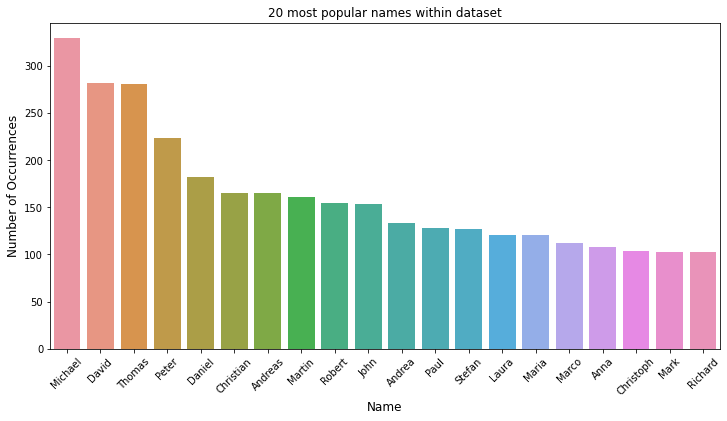

In [24]:
authors_cleaned_df.lastname.value_counts()

plt.figure(figsize=(12,6))
plt.xticks(rotation=45)
sns.barplot(x=names, y=values)
plt.title("20 most popular names within dataset")
plt.ylabel("Number of Occurrences", fontsize=12)
plt.xlabel("Name", fontsize=12)
plt.show()

## Preprocess column with affiliations

**Basically, I was not sure if this part of the task is actually required, as it is mentioned in its content, but the exemplary output suggests that only the names of the researchers need to be extracted.**

**Additionally, carrying out both tasks satisfactorily would require exceeding the time allotted for the task ~ 4 hours. So I proposed a solution that sets a list of unique institutions, but contains several problems that should be worked on, devoting more time to it (e.g. often the name of the institution is the scientist's email or only the city in which he works).**

In [25]:
affiliations = publications_df.affiliations.dropna(how="all")
affiliations

0       National Institutes of Health, Laboratory of T...
1                                      , , , , , , , , , 
2                                      , , , , , , , , , 
3       Istituto di Anestesiologia e Rianimazione, Uni...
4                                        , , , , , , , , 
                              ...                        
9994    Riley Child Development Center, Department of ...
9995    Department of Developmental Biology, Max Planc...
9996    Vienna, Austria., Vienna, Austria., Vienna, Au...
9997    Division of Cardiac Thoracic Vascular Anesthes...
9998    Department of Neuroanatomy and Molecular Brain...
Name: affiliations, Length: 9506, dtype: object

In [26]:
# Remove non alpahnumeric characters
affiliations_temp = affiliations.apply(strip_non_alphanum)
# Empty spaces are the leftovers from empty records like ', , ,'
affiliations = affiliations[affiliations_temp[~affiliations_temp.str.isspace()].index]

In [27]:
affiliations

0       National Institutes of Health, Laboratory of T...
3       Istituto di Anestesiologia e Rianimazione, Uni...
5       Istituto di Anestesiologia e Rianimazione, Uni...
7       Istituto Nazionale Genetica Molecolare, Milano...
9       Istituto di Anestesiologia e Rianimazione, IRC...
                              ...                        
9994    Riley Child Development Center, Department of ...
9995    Department of Developmental Biology, Max Planc...
9996    Vienna, Austria., Vienna, Austria., Vienna, Au...
9997    Division of Cardiac Thoracic Vascular Anesthes...
9998    Department of Neuroanatomy and Molecular Brain...
Name: affiliations, Length: 8138, dtype: object

In [28]:
def split_by_country(institutes):
    """Takes string and splits it in a place where there is country name with a single dot"""
    countries = [country.name for country in pycountry.countries if country.name in institutes]

    institutes = [institutes]
    for country in countries:
        institutes = [text.split(country + ".") for text in institutes]
        institutes = sum(institutes, [])

    return institutes


def unify_institutions(institutes):
    """Takes institutions name form list of strings in format: Institution Name, Some info, Some info, Country."""
    countries = [country.name for country in pycountry.countries if country.name in institutes]

    institutes = split_by_country(institutes)

    # Remove commas at the beggining of each line after splitting by country
    for institute in institutes:
        institutes = ['\n'.join(i.lstrip(', ') for i in institute.splitlines()) for institute in institutes]

    # Get rid of empty strings in list
    institutes = list(filter(None, institutes))
    # Take only insitution name and throw away rest of informations (controversial!)
    institutes = [institute.split(", ", 1) for institute in institutes]
    _ = [institute.pop() for institute in institutes]
    # Flatten list
    institutes = list(itertools.chain.from_iterable(institutes))

    return institutes

In [29]:
# Example
text = affiliations[224]
print(text)
print(unify_institutions(text))

ETH Zurich, Department of Health Science and Technology, Institute of Food, Nutrition and Health, Laboratory of Human Nutrition, Zurich, Switzerland nicole.stoffel@hest.ethz.ch., ETH Zurich, Department of Health Science and Technology, Institute of Food, Nutrition and Health, Laboratory of Human Nutrition, Zurich, Switzerland., Columbia University, Department of Pediatrics, College of Physicians and Surgeons, New York, NY, USA., ETH Zurich, Department of Health Science and Technology, Institute of Food, Nutrition and Health, Laboratory of Human Nutrition, Zurich, Switzerland., ETH Zurich, Department of Health Science and Technology, Institute of Food, Nutrition and Health, Laboratory of Human Nutrition, Zurich, Switzerland.
['ETH Zurich', 'Columbia University', 'ETH Zurich']


In [30]:
affiliations = affiliations.apply(unify_institutions)

In [31]:
institutions_df = pd.DataFrame(affiliations.explode().unique(), columns=["institution"]).dropna()
institutions_df = institutions_df.sort_values(by="institution")
institutions_df.sample(10)

,institution
9418,Division of Medicinal Chemistry
10348,Department of Neuropsychology and Psychopharma...
8794,Penn Medicine Lancaster General Hospital and P...
7938,Service of Immunology and Allergology
10321,Mississippi State University
502,caterina.cascini91@gmail.com.
7947,Hopital A Mignot - Centre Hospitalier de Versa...
10933,johann.reisinger@bhs.at
1419,Institute of Structural Biology
2351,Electronic address: stefanie.kraemer@pharma.et...


In [32]:
institutions_df.to_csv("./unique_institutions.csv", index=False)